In [1]:
import os
import warnings
import json
from google.cloud import storage
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm
import re
import gcsfs
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from google.cloud import storage, bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/mnt/disks/data/diss_bucket_key.json"
# Turn off all warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ["HF_DATASETS_CACHE"] = "/mnt/disks/data/hf_cache"
os.environ["HF_DATASETS_OFFLINE"] = "1"  # Optional: if you're only working locally
os.environ["TRANSFORMERS_CACHE"] = "/mnt/disks/data/transformers_cache"
os.environ["TMPDIR"] = "/mnt/disks/data/tmp"

In [3]:
# Detect number of GPUs
gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {gpus}")
print(torch.cuda.get_device_name(0))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Number of GPUs available: 1
NVIDIA A100-SXM4-40GB


In [4]:
# Setup
BUCKET_NAME = "diss_market_data"
MODEL_PREFIX = "finbert-finetuned_onlyfilings/"
MODEL_LOCAL_DIR = "finbert_onlyfilings"

# === Configuration ===
PROJECT_ID = "bamboo-mercury-462915-f0"
BQ_DATASET = "edgar_sentiment"
BQ_TABLE_EVAL = "filing_scores_evaluation"
REGION = "europe-west2"
OUTPUT_DIR = f"gs://diss_market_data/finbert-finetune-output"
NUM_LABELS = 3

In [5]:
# === Environment Variables for HPC ===
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["NCCL_P2P_DISABLE"] = "1"

In [6]:
# === Extract data from BigQuery for training ===
bq_client = bigquery.Client()
query = f"""SELECT *
        FROM (
          (
            SELECT chunk_text, sentiment_score, sentiment_label
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_EVAL}`
            WHERE sentiment_label = 'Positive'
            ORDER BY FARM_FINGERPRINT(CONCAT(CAST(12345 AS STRING), chunk_text))
            LIMIT 45
          )
          UNION ALL
          (
            SELECT chunk_text, sentiment_score, sentiment_label
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_EVAL}`
            WHERE sentiment_label = 'Negative'
            ORDER BY FARM_FINGERPRINT(CONCAT(CAST(12345 AS STRING), chunk_text))
            LIMIT 45
          )
          UNION ALL
          (
            SELECT chunk_text, sentiment_score, sentiment_label
            FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_EVAL}`
            WHERE sentiment_label = 'Neutral'
            ORDER BY FARM_FINGERPRINT(CONCAT(CAST(12345 AS STRING), chunk_text))
            LIMIT 45
          )
        )
        ORDER BY FARM_FINGERPRINT(CONCAT(CAST(12345 AS STRING), chunk_text));
        """
df_filings = bq_client.query(query).to_dataframe()
print(f"Retrieved {len(df_filings)} rows from filings training table {BQ_DATASET}.{BQ_TABLE_EVAL}")

Retrieved 135 rows from filings training table edgar_sentiment.filing_scores_evaluation


In [7]:
# ------------------------ Load Model -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_LOCAL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_LOCAL_DIR).to(DEVICE)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# ---------- Basic hygiene ----------
df = df_filings.dropna(subset=["chunk_text", "sentiment_label"]).copy()
# -- Saving the file to review --
df.to_csv("filings_human_eval.csv", index=False)

texts = df["chunk_text"].astype(str).tolist()
true_labels_str = df["sentiment_label"].astype(str).tolist()

In [9]:
# Canonicalise common label names
def canon(s: str) -> str:
    s = s.strip().lower()
    alias = {"pos": "positive", "neg": "negative", "neu": "neutral"}
    return alias.get(s, s)

true_labels_str = [canon(x) for x in true_labels_str]


In [10]:
# Try to use the model's label mapping if available and compatible
cfg_label2id_raw = getattr(model.config, "label2id", None) or {}
cfg_id2label_raw = getattr(model.config, "id2label", None) or {}

In [11]:
# Normalise keys/cases
cfg_label2id = {str(k).lower(): int(v) for k, v in cfg_label2id_raw.items()} if cfg_label2id_raw else {}
cfg_id2label = {int(k): str(v) for k, v in cfg_id2label_raw.items()} if cfg_id2label_raw else {}

model_knows_std_labels = {"positive", "negative", "neutral"}.issubset(set(cfg_label2id.keys()))


In [12]:
if model_knows_std_labels:
    label2id = cfg_label2id
    id2label = {v: k for k, v in label2id.items()}
else:
    # Fallback: derive mapping from your dataset (stable alphabetical order)
    unique_labels = sorted(set(true_labels_str))
    label2id = {lab: i for i, lab in enumerate(unique_labels)}
    id2label = {i: lab for lab, i in label2id.items()}

In [13]:
# Encode ground truth as ids
y_true = np.array([label2id[canon(x)] for x in true_labels_str], dtype=int)

In [14]:
# ---------- Tokenise ----------
# Choose a safe max length
try:
    max_len_model = int(getattr(tokenizer, "model_max_length", 512))
except Exception:
    max_len_model = 512
MAX_LEN = min(512, max_len_model if max_len_model > 0 else 512)

enc = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

dataset = TensorDataset(enc["input_ids"], enc["attention_mask"])
BATCH_SIZE = 32
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# ---------- Inference ----------
model.eval()
all_logits = []

with torch.no_grad():
    for input_ids, attention_mask in tqdm(loader, desc="Evaluating"):
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        out = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits.append(out.logits.detach().cpu())

logits = torch.cat(all_logits, dim=0).numpy()
y_pred = logits.argmax(axis=1)


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


In [16]:
# If we used a fallback label space but the model outputs a different number of classes,
# we still evaluate by numeric ids; display names come from 'id2label'.
target_order = list(range(len(id2label)))  # order for report/cm
target_names = [id2label[i].capitalize() for i in target_order]

In [17]:
# ---------- Metrics ----------
print("Accuracy: {:.3f}".format(accuracy_score(y_true, y_pred)))
print("Weighted F1: {:.3f}".format(f1_score(y_true, y_pred, average="weighted")))
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, labels=target_order, target_names=target_names, digits=3))

Accuracy: 0.733
Weighted F1: 0.728

Classification report:

              precision    recall  f1-score   support

     Neutral      0.625     0.667     0.645        45
    Positive      0.897     0.578     0.703        45
    Negative      0.741     0.956     0.835        45

    accuracy                          0.733       135
   macro avg      0.754     0.733     0.728       135
weighted avg      0.754     0.733     0.728       135



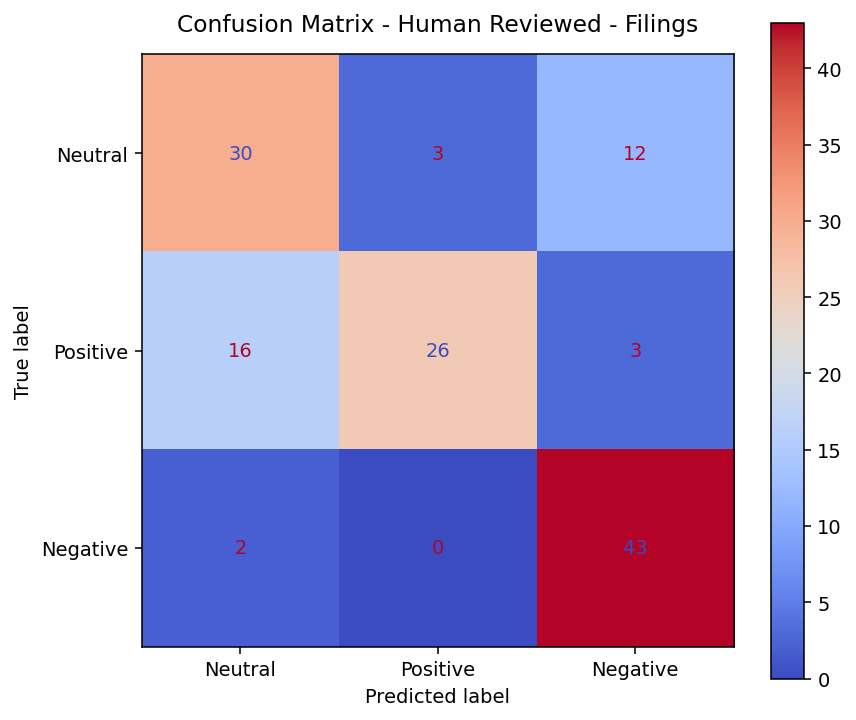

<Figure size 640x480 with 0 Axes>

In [22]:
# ---------- Confusion Matrices (counts and normalised) ----------
cm = confusion_matrix(y_true, y_pred, labels=target_order)
cm_norm = confusion_matrix(y_true, y_pred, labels=target_order, normalize="true")

def plot_cm(cm_mat, labels, title, normalised=False, cmap_name="coolwarm"):
    fig, ax = plt.subplots(figsize=(6.5, 5.5), dpi=140)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat, display_labels=labels)
    disp.plot(ax=ax, cmap=cmap_name, colorbar=True, values_format=".2f" if normalised else "d")
    ax.set_title(title, pad=12)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.gcf().savefig("confusion_matrix_human_reviewed_filings.png", dpi=300, bbox_inches="tight")

plot_cm(cm, target_names, "Confusion Matrix - Human Reviewed - Filings", normalised=False)

# plot_cm(cm_norm, target_names, "Confusion Matrix (Normalised by True Class)", normalised=True)
# plt.gcf().savefig("confusion_matrix_normalised_trueclass.png", dpi=300, bbox_inches="tight")
